In [1]:
import d2l 
from mxnet import *
from IPython import display
npx.set_np()

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## INITIAL MODEL PARAMETERS

In [3]:
num_inputs = 784
num_outputs = 10

w = np.random.normal(0, 0.01, (num_inputs, num_outputs))
b = np.zeros(num_outputs)

In [4]:
w.attach_grad()
b.attach_grad()


## SOFTMAX

In [5]:
X = np.array([[1,2,3], [4,5,6]])


In [6]:
def softmax(X):
    X_exp = np.exp(X)
    partition = X_exp.sum(axis=1, keepdims=True)
    return X_exp / partition

In [7]:
X = np.random.normal(size=(2,5))
X_prob = softmax(X)
X_prob, X_prob.sum(axis=1)

(array([[0.06461646, 0.21712114, 0.29075104, 0.06388352, 0.3636278 ],
        [0.6120887 , 0.20559113, 0.03352184, 0.05169575, 0.09710258]]),
 array([0.99999994, 1.        ]))

## MODEL

In [8]:
def net(X):
    return softmax(np.dot(X.reshape(-1, num_inputs), w) + b)

## LOSS

In [9]:
y_hat = np.array([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0,1], [0,2]]

array([0.1, 0.5])

In [10]:
def cross_entropy(y_hat, y):
    return  - np.log(y_hat[range(len(y_hat)), y])

## CLASSIFICATION ACC

In [12]:
def accuracy(y_hat, y):
    if y_hat.shape[1] > 1:
        return float((y_hat.argmax(axis=1).astype('float32') == y.astype('float32')).sum())
    else:
        return float((y_hat.astype('int32') == y.astype('int32')).sum())

In [13]:
y= np.array([0,2])
accuracy(y_hat, y) / len(y)

0.5

In [14]:
def evaluate_accuracy(net, data_iter):
    metric = Accumulator(2)
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.size)
    return metric[0] / metric[1]

In [15]:
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a+float(b) for a,b in zip(self.data, args)] 
    def reset(self):
        self.data = [0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [16]:
evaluate_accuracy(net, test_iter)

0.1257

## TRAINING

In [17]:
def train_epoch_ch3(net, train_iter, loss, updater):
    metric = Accumulator(3)
    if isinstance(updater, gluon.Trainer):
        updater = updater.step
    for X,y in train_iter:
        with autograd.record():
            y_hat = net(X)
            l = loss(y_hat, y)
        l.backward()
        updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.size)
    
    return metric[0] / metric[2], metric[1] / metric[2]

        

In [24]:
class Animator:
    def __init__(self, xlabel= None, ylabel = None, legend =None, xlim = None,
                ylim = None, xscale='linear', yscale='linear', fmts=None,
                nrows=1, ncols =1, figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        d2l.use_svg_display()
        
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        
        self.config_axes = lambda: d2l.set_axes(self.axes[0],
                                               xlabel, ylabel, xlim, ylim,
                                               xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
            
    def add(self, x,y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        
        if not hasattr(x, "__len__"):
            x = [x] * n
    
        if not self.X:
            self.X = [[] for _ in range(n)]
        
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        
        if not self.fmts:
            self.fmts = ['-'] * n
        
        for i, (a,b) in enumerate(zip(x,y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x,y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x,y,fmt)
        
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [25]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel = 'epoch', xlim=[1, num_epochs],
                       ylim =[0.3, 0.9],
                       legend=['train_loss', 'train_acc', 'test_acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch+1, train_metrics+(test_acc,))

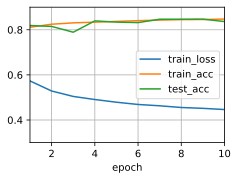

In [26]:
num_epochs = 10
lr = 0.1

def updater(batch_size):
    return d2l.sgd([w,b], lr, batch_size)

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

## PREDICTION

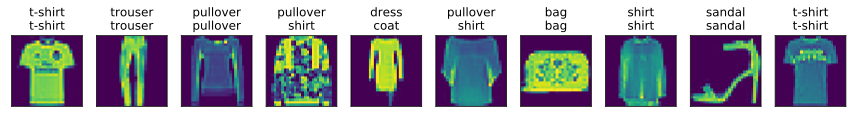

In [29]:
def predict_ch3(net, test_iter, n=10):
    for X,y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true+'\n'+pred for true, pred in zip(trues,preds)]
    d2l.show_images(X[0:n].reshape(n,28,28), 1, n, titles = titles[0:n])

predict_ch3(net,test_iter)